# 📜 Análise de dados entre videos do Youtube e os stocks de grandes empresas 📜 

Desde a estabilização do comércio internacional a nível mundial que as empresas têm tido um crescimento exponencial, impulsionado por diversos fatores, incluindo a inovação tecnológica e a globalização. Nos últimos anos, o crescimento de plataformas de divulgação e compartilhamento de vídeos têm um papel significativo na promoção de marcas, produtos e serviços, influenciando a percepção dos consumidores e, consequentemente, o desempenho financeiro das empresas. <br>

Este projeto tem como objetivo analisar o impacto das visualizações de vídeos no YouTube sobre empresas específicas, avaliando como a exposição digital pode influenciar o crescimento das organizações e o valor das suas ações no mercado bolsista. Através de uma abordagem que combina análise de dados, economia e marketing digital, pretende-se compreender de que forma métricas como visualizações, interações e popularidade de conteúdo podem ser indicadores de tendências de investimento e valorização empresarial.

## Importar Bibliotecas

In [1]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark import SparkContext
from datetime import datetime
from functools import reduce
from pyspark.sql.functions import sum
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
#import matplotlib.cm as cm 
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

## Criação do Spark para ser utilizado em PySpark

In [3]:
spark_ = SparkSession.builder \
    .appName("company_database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

### Datasets
Para a realização deste trabalho, foram utilizados 14 datasets que se dividem em dois grupos principais: os datasets de vídeos do YouTube e datasets de stocks de empresas.

## Importanção dos dados de cada pais
Datasets de vídeos do youtube <br>
Os dados destes datasets são provenientes de oito diferentes países, dos quais: Brasil, Estados Unidos (US), Canadá, França, Inglaterra, Índia, Coreia do Sul e México.

In [4]:
df_us = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_us").load()
df_br = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_br").load()
df_ca = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_ca").load()
df_fr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_fr").load()
df_gb = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_gb").load()
df_in = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_in").load()
df_kr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_kr").load()
df_mx = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_mx").load()

## Importanção dos dados de empresa
Datasets de stocks de empresas <br>
Os datasets sobre os stocks de empresas fornecem dados de seis organizações distintas: Sony, Nvidia, Microsoft, Dell, IBM, Intel

In [5]:
df_dell = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.dell_data").load()
df_ibm = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.ibm_data").load()
df_intel = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.intel_data").load()
df_microsoft = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.microsoft_data").load()
df_nvidia = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.nvidia_data").load()
df_sony = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.sony_data").load()

## Dicionario das empresas e seus nomes para posteriormente fazer a união dos dfs com a coluna company_name
A ideia é juntar todos os dataframes num só. Para isso, necessitamos de criar uma nova coluna que identifique a que empresa a linha do stock está ligada

In [6]:
dict_companies = {'companies': [
                 {'dataframe':df_dell, 'name': 'dell'},
                 {'dataframe':df_ibm, 'name': 'ibm'},
                 {'dataframe':df_intel, 'name': 'intel'},
                 {'dataframe':df_microsoft, 'name': 'microsoft'},
                 {'dataframe':df_nvidia, 'name': 'nvidia'},
                 {'dataframe':df_sony, 'name': 'sony'},  
                ]
            }

In [7]:
for company in dict_companies['companies']:
    company["dataframe"] = company["dataframe"].withColumn("company_name", lit(company["name"]))

In [8]:
df_companies = dict_companies['companies'][0]['dataframe'].union(dict_companies['companies'][1]['dataframe']).union(dict_companies['companies'][2]['dataframe']).union(dict_companies['companies'][3]['dataframe']).union(dict_companies['companies'][4]['dataframe']).union(dict_companies['companies'][5]['dataframe'])

In [9]:
#df_us.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)



In [10]:
companies = ['nvidia', 'dell', 'ibm', 'intel', 'microsoft', 'sony']
countries_df = [df_us, df_br, df_ca, df_fr, df_gb, df_in, df_kr, df_mx]
countries = ['us', 'br', 'ca', 'fr', 'gb', 'in', 'kr', 'mx']

yt = {company: {} for company in companies}

def filter_df(df, company):
    filtered_df = df.filter(
        (col('title').contains(company.capitalize())) |
        (col('title').contains(company.upper())) |
        (col('channelTitle').contains(company.capitalize())) |
        (col('channelTitle').contains(company.upper()))
    )
    return filtered_df.withColumn("company", lit(company))

for company in companies:
    for country, country_df in zip(countries, countries_df):
        filtered_data = filter_df(country_df, company)
        yt[company].setdefault(country, []).append(filtered_data)

        

## União dos df de cada pais num só

In [11]:
all_dfs = [
    df 
    for company, country_data in yt.items() 
    for country, dfs in country_data.items() 
    for df in dfs
]

if all_dfs:
    df_yt = reduce(lambda df1, df2: df1.union(df2), all_dfs)
else:
    df_yt = None  


In [12]:
#df_yt.count()

9958

## Colunas existentes

In [13]:
#df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



In [14]:
#df_companies.count()

51110

## União dos videos de cada empresa

df_yt_companies - todos os videos das empresas a serem estudadas<br> 
df_all_companies - dados de todas as empreas a serem estudadas

## Estudo dos nulos

In [15]:
# YT
df_yt.select([count(when(col(c).isNull(), c)).alias(c) for c in df_yt.columns]).show()

+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|_id|categoryId|channelId|channelTitle|comment_count|comments_disabled|description|dislikes|likes|publishedAt|ratings_disabled|tags|thumbnail_link|title|trending_date|video_id|view_count|company|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|  0|         0|        0|           0|            0|                0|          0|       0|    0|          0|               0|   0|             0|    0|            0|       0|         0|      0|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+



In [16]:
duplicates = df_yt.groupBy("title").count().filter("count > 1")
duplicates.show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|EVGA Terminates N...|   18|
|I've never held s...|    9|
|BREAKING NEWS! - ...|   15|
|NVIDIA... You've ...|   18|
|NVIDIA GeForce RT...|   15|
|Nvidia was clearl...|   19|
|ITS HERE - NVIDIA...|   16|
|NVIDIA finally an...|    5|
|NVIDIA REFUSED To...|   14|
|NVIDIA GeForce RT...|   13|
|NVIDIA just made ...|   22|
|Nvidia tried to b...|    8|
|NVIDIA 40 Series ...|    9|
|Nvidia, you PROMI...|   14|
|NVIDIA Never saw ...|   15|
|NVIDIA expects to...|    4|
|NVIDIA RTX 3090, ...|   13|
|NVIDIA... why do ...|   18|
|NVIDIA's RTX 4080...|   28|
|Black Myth: Wukon...|   14|
+--------------------+-----+
only showing top 20 rows



In [17]:
df_yt = df_yt.dropDuplicates(["title"])

In [18]:
#df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



In [19]:
df_companies.select([count(when(col(c).isNull(), c)).alias(c) for c in df_companies.columns]).show()

+---------+-----+----+----+---+----+------+---+------------+
|Adj Close|Close|Date|High|Low|Open|Volume|_id|company_name|
+---------+-----+----+----+---+----+------+---+------------+
|        0|    0|   0|   0|  0|   0|     0|  0|           0|
+---------+-----+----+----+---+----+------+---+------------+



In [20]:
duplicates = df_companies.groupBy("Date").count().filter("count > 1")
duplicates.show()

df_cleaned = df_companies.dropDuplicates(["Date"])

+----------+-----+
|      Date|count|
+----------+-----+
|2016-08-17|    6|
|2017-12-05|    6|
|2019-08-08|    6|
|2019-08-22|    6|
|2019-08-23|    6|
|2020-02-26|    6|
|2020-04-13|    6|
|2021-11-03|    6|
|2022-10-05|    6|
|2023-05-01|    6|
|2023-05-18|    6|
|2024-01-19|    6|
|2024-08-20|    5|
|2024-10-24|    5|
|2017-02-24|    6|
|2017-05-11|    6|
|2017-10-20|    6|
|2017-12-22|    6|
|2018-12-31|    6|
|2019-04-25|    6|
+----------+-----+
only showing top 20 rows



## Passar publishedAt e Date de string para data

In [21]:
#df_companies.show(5)

+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open| Volume|                 _id|company_name|
+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|11.263914108276367|12.067675590515137|2016-08-17|12.348319053649902|12.067675590515137| 12.20799732208252| 271519|{676ed5373c6e8c55...|        dell|
|11.198426246643066|11.997514724731444|2016-08-18|12.348319053649902|11.927353858947754|12.348319053649902|1767366|{676ed5373c6e8c55...|        dell|
|11.394889831542969| 12.20799732208252|2016-08-19| 12.20799732208252|11.969449996948242|11.983482360839844|4735900|{676ed5373c6e8c55...|        dell|
|11.434185028076172|12.250094413757324|2016-08-22|12.797348976135254| 11.95541763305664|12.067675590

In [22]:
df_yt = df_yt.withColumn(
    "publishedAt",
    to_date(df_yt.publishedAt, "yyyy-MM-dd'T'HH:mm:ss'Z'")
)


In [23]:
df_companies = df_companies.withColumn(
    "Date",
    to_date(df_companies.Date, "yyyy-MM-dd")
)


In [24]:
#df_yt.show(5)

+--------------------+----------+--------------------+--------------+-------------+-----------------+--------------------+--------+-----+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+-------+
|                 _id|categoryId|           channelId|  channelTitle|comment_count|comments_disabled|         description|dislikes|likes|publishedAt|ratings_disabled|                tags|      thumbnail_link|               title|       trending_date|   video_id|view_count|company|
+--------------------+----------+--------------------+--------------+-------------+-----------------+--------------------+--------+-----+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+-------+
|{6771351a4f35cf01...|        22|UCj4Gswu3khzeRLMb...|Surbhi Rathore|          541|            false|                 NaN|    1183|13673| 2021-03-13|     

In [25]:
#df_companies.show(5)

+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open| Volume|                 _id|company_name|
+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|11.263914108276367|12.067675590515137|2016-08-17|12.348319053649902|12.067675590515137| 12.20799732208252| 271519|{676ed5373c6e8c55...|        dell|
|11.198426246643066|11.997514724731444|2016-08-18|12.348319053649902|11.927353858947754|12.348319053649902|1767366|{676ed5373c6e8c55...|        dell|
|11.394889831542969| 12.20799732208252|2016-08-19| 12.20799732208252|11.969449996948242|11.983482360839844|4735900|{676ed5373c6e8c55...|        dell|
|11.434185028076172|12.250094413757324|2016-08-22|12.797348976135254| 11.95541763305664|12.067675590

In [26]:
#df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: date (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



## Tags String to Array sem nulos

In [27]:
df_transformed = df_yt.withColumn("tags_arr", split(col("tags"), "\|")).drop("tags")

In [28]:
df_transformed.show(5)

+--------------------+----------+--------------------+--------------+-------------+-----------------+--------------------+--------+-----+-----------+----------------+--------------------+--------------------+--------------------+-----------+----------+-------+--------------------+
|                 _id|categoryId|           channelId|  channelTitle|comment_count|comments_disabled|         description|dislikes|likes|publishedAt|ratings_disabled|      thumbnail_link|               title|       trending_date|   video_id|view_count|company|            tags_arr|
+--------------------+----------+--------------------+--------------+-------------+-----------------+--------------------+--------+-----+-----------+----------------+--------------------+--------------------+--------------------+-----------+----------+-------+--------------------+
|{6771351a4f35cf01...|        22|UCj4Gswu3khzeRLMb...|Surbhi Rathore|          541|            false|                 NaN|    1183|13673| 2021-03-13|     

In [29]:
df_transformed.select("tags_arr").show(5)

+--------------------+
|            tags_arr|
+--------------------+
|            [[None]]|
|[Microsoft Surfac...|
|[call of duty, co...|
|[sony pal shows, ...|
|[deepthi sunaina ...|
+--------------------+
only showing top 5 rows



In [30]:
#df_transformed.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: date (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)
 |-- tags_arr: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [31]:
#df_companies.printSchema()

root
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- company_name: string (nullable = false)



In [32]:
#df_transformed.count()

2283

## Plots

/tmp/ipykernel_10965/2767517119.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


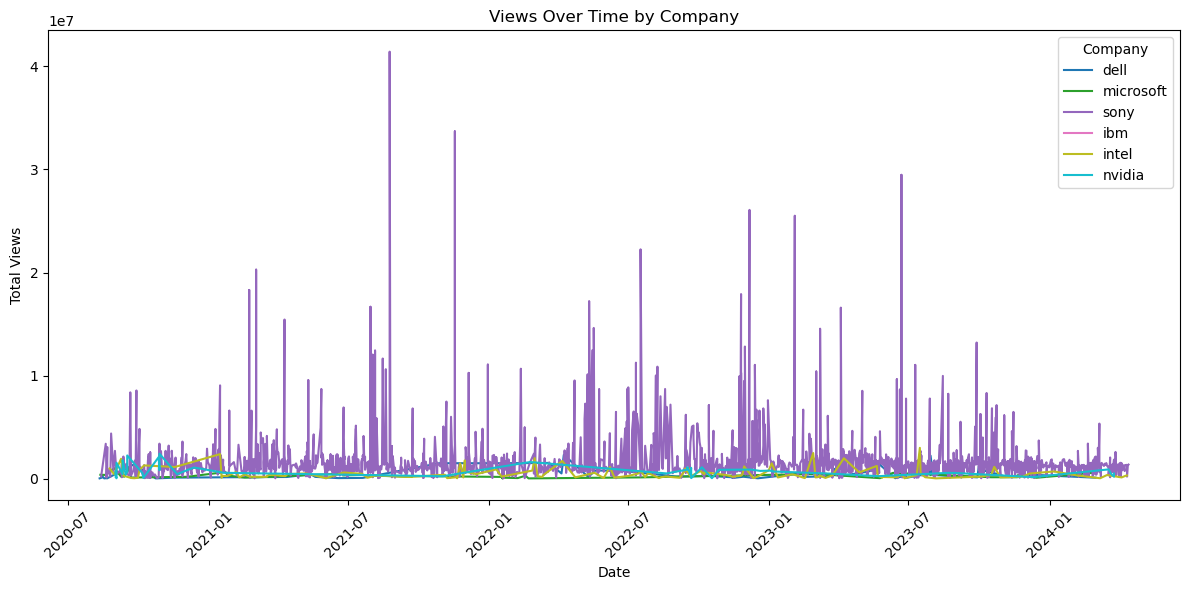

In [33]:
df_views_over_time = df_transformed.withColumn("published_date", to_date(col("publishedAt"))).groupBy(
    "published_date", "company", "title", "view_count"
).agg(
    spark_sum("view_count").alias("total_views")
).orderBy("published_date")

colors = plt.cm.get_cmap('tab10', len(companies))
plot_data_yt = df_views_over_time.toPandas() 
plt.figure(figsize=(12, 6))
companies = plot_data_yt["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt[plot_data_yt["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )
plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
plot_data_yt = df_views_over_time.toPandas() 

In [35]:
# df_combined = df_companies.join(
#     df_yt,
#     df_companies["company_name"] == df_yt["company"],
#     how="inner"
# ).select("Date", "Adj Close", "company_name", "likes", "view_count")

# df_combined

In [36]:
plot_data_companies = df_companies.toPandas()

/tmp/ipykernel_10965/2039972490.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


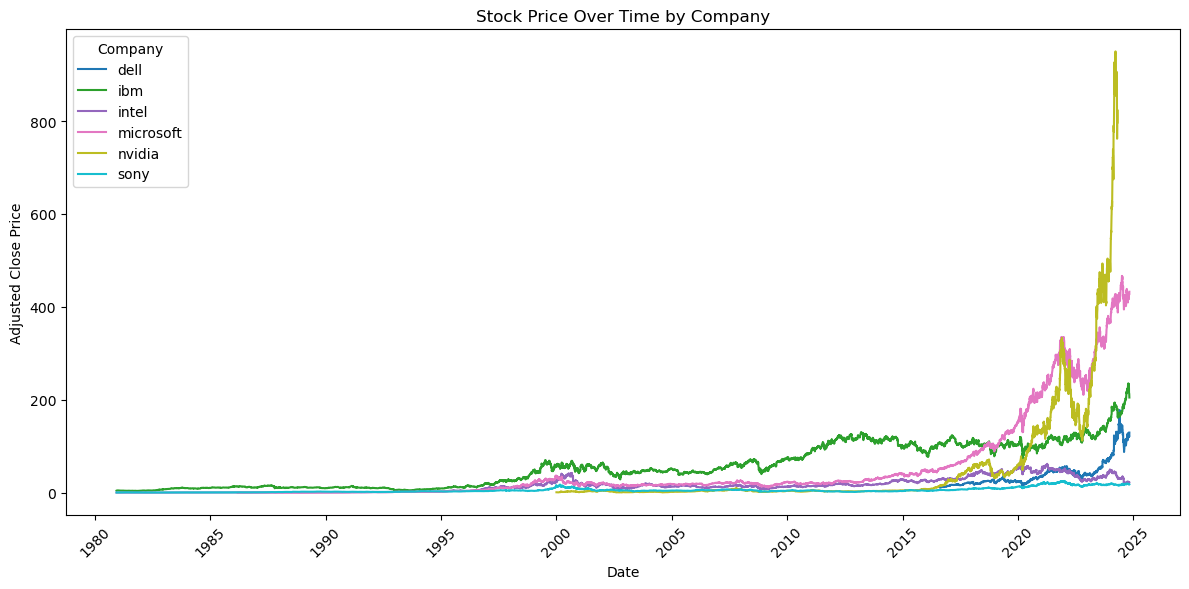

In [37]:
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))
for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# AQUELA LINHA DA NVIDIA, QUE DEVIA CONTINUAR PARA A FRENTE (COMO AS OUTRAS) MANDOU O FODA SE AHHAHAHAAHA

/tmp/ipykernel_10965/2024041847.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


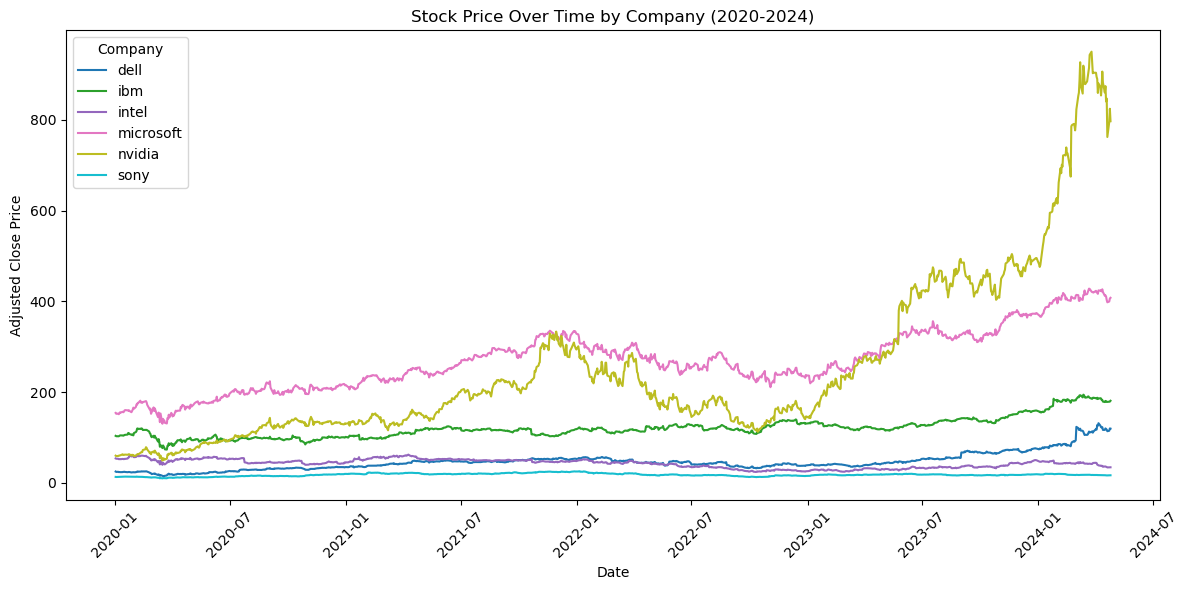

In [38]:
plot_data_filtered = df_companies.filter(
    (col("Date") >= "2020-01-01") & (col("Date") <= "2024-04-24")
)

plot_data_companies = plot_data_filtered.toPandas()
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
plot_data_yt_company = plot_data_yt[
    (plot_data_yt["company"] != "ibm") &
    (plot_data_yt["company"] != "microsoft") &
    (plot_data_yt["company"] != "nvidia") &
    (plot_data_yt["company"] != "dell") &
    (plot_data_yt["company"] != "intel")
]


In [40]:
plot_data_yt_company

,published_date,company,title,view_count,total_views
2,2020-08-13,sony,Main Tumhara - Dil Bechara|Official Lyric Vide...,214441,214441
8,2020-08-19,sony,Ishq Kamaal – Sadak 2 | Javed Ali | Suniljeet-...,3385888,3385888
10,2020-08-20,sony,Doctor - Nenjame Music Video | Sivakarthikeyan...,1103512,1103512
11,2020-08-20,sony,Khulke Jeene Ka - Dil Bechara|Lyric Video|Sush...,104810,104810
12,2020-08-21,sony,Dikkiloona - Official Trailer | Santhanam | Yu...,3065884,3065884
...,...,...,...,...,...
2277,2024-04-10,sony,NEW! Taarak Mehta Ka Ooltah Chashmah | Ep 4055...,1327011,1327011
2279,2024-04-11,sony,NEW! Taarak Mehta Ka Ooltah Chashmah | Ep 4056...,1343002,1343002
2280,2024-04-11,sony,घने जंगल में हुआ Team CID पर हमला | CID | Homi...,198132,198132
2281,2024-04-12,sony,NEW! Taarak Mehta Ka Ooltah Chashmah | Ep 4057...,1286131,1286131


In [41]:
plot_data_companies_company = plot_data_companies[
    (plot_data_companies["company_name"] != "ibm") &
    (plot_data_companies["company_name"] != "microsoft") &
    (plot_data_companies["company_name"] != "nvidia") &
    (plot_data_companies["company_name"] != "dell") &
    (plot_data_companies["company_name"] != "intel")
]

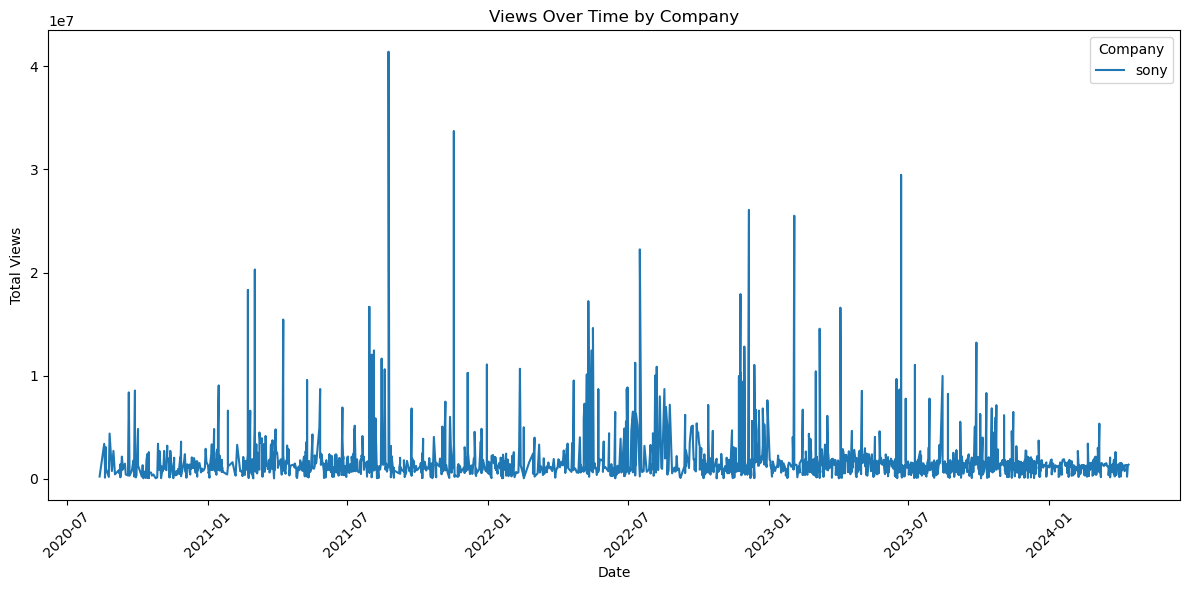

In [42]:
plt.figure(figsize=(12, 6))
companies = plot_data_yt_company["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt_company[plot_data_yt_company["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )
plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_10965/2239544597.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


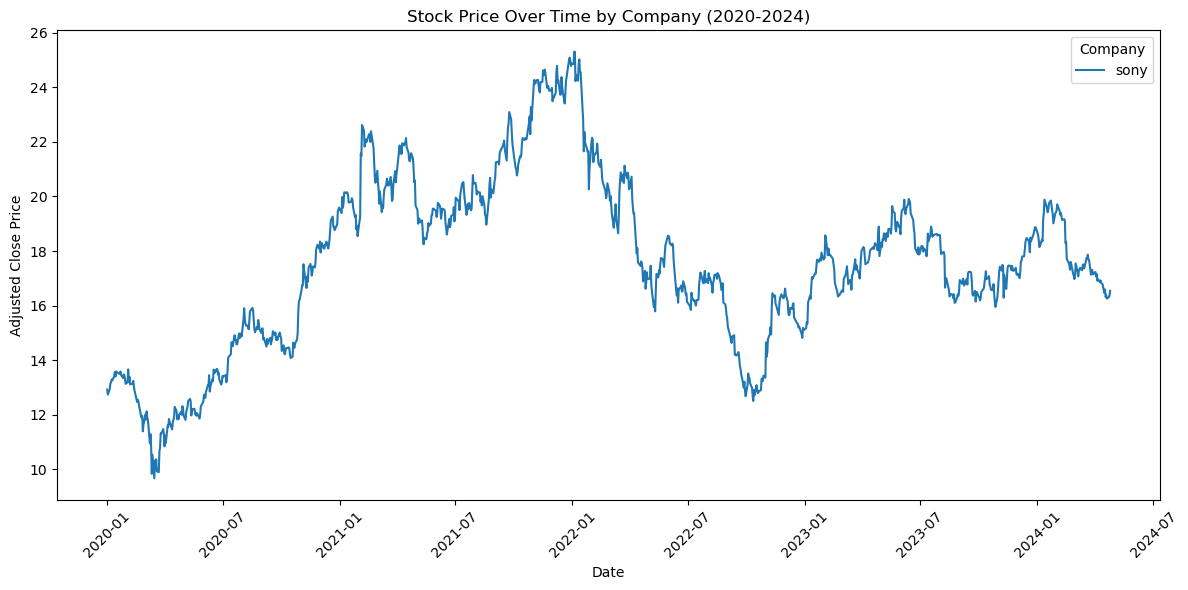

In [43]:
plt.figure(figsize=(12, 6))
companies = plot_data_companies_company["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))
for i, company in enumerate(companies):
    company_data = plot_data_companies_company[plot_data_companies_company["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))
plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())


/tmp/ipykernel_10965/3912450172.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_yt_company["normalized_views"] = normalize(plot_data_yt_company["total_views"])
/tmp/ipykernel_10965/3912450172.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_companies_company["normalized_stocks"] = normalize(plot_data_companies_company["Adj Close"])
/tmp/ipykernel_10965/3912450172.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two m

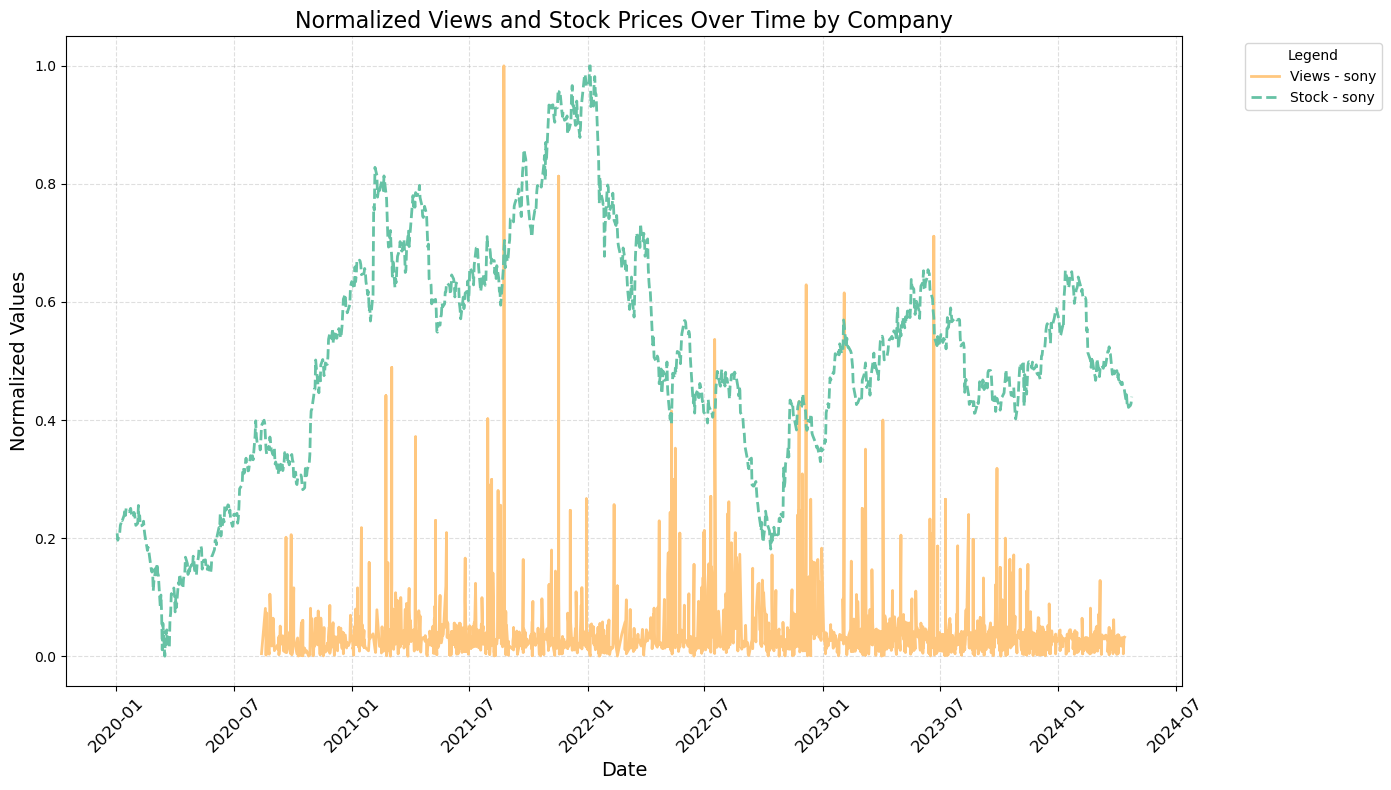

In [44]:
if 'published_date' not in plot_data_yt_company.columns:
    plot_data_yt_company['published_date'] = pd.to_datetime(plot_data_yt_company['published_date'], errors='coerce')


plot_data_yt_company["normalized_views"] = normalize(plot_data_yt_company["total_views"])
plot_data_companies_company["normalized_stocks"] = normalize(plot_data_companies_company["Adj Close"])

colors_views = cm.get_cmap('copper', len(plot_data_yt_company["company"].unique()))
colors_stocks = cm.get_cmap('Set2', len(plot_data_companies_company["company_name"].unique()))


plt.figure(figsize=(14, 8))
for i, company in enumerate(plot_data_yt_company["company"].unique()):
    company_data = plot_data_yt_company[plot_data_yt_company["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["normalized_views"],
        label=f"Views - {company}",
        color=colors_views(i),
        linestyle='-',  
        linewidth=2
    )
for i, company in enumerate(plot_data_companies_company["company_name"].unique()):
    company_data = plot_data_companies_company[plot_data_companies_company["company_name"] == company]
    plt.plot(
        company_data["Date"],
        company_data["normalized_stocks"],
        label=f"Stock - {company}",
        color=colors_stocks(i),
        linestyle='--',  
        linewidth=2
    )
plt.title("Normalized Views and Stock Prices Over Time by Company", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Normalized Values", fontsize=14)
plt.legend(title="Legend", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.xticks(rotation=45, fontsize=12)
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()



In [45]:
top_5_microsoft = plot_data_yt[plot_data_yt["company"] == "microsoft"].nlargest(5, "view_count")
top_5_nvidia = plot_data_yt[plot_data_yt["company"] == "nvidia"].nlargest(5, "view_count")

print("Top 5 vídeos da Microsoft:")
print(top_5_microsoft[["title", "view_count", "published_date"]])
print("\nTop 5 vídeos da NVIDIA:")
print(top_5_nvidia[["title", "view_count", "published_date"]])


Top 5 vídeos da Microsoft:
                                                 title  view_count  \
20                 Microsoft Surface Duo Unboxing. Wow     1023918   
49   Microsoft Duo Durability Test! - How Thin is t...      999171   
833        How Microsoft buys out every gaming company      803071   
493  Windows 11: Microsoft CEO Satya Nadella on the...      698557   
240         Microsoft Surface Pro 7: The Better Choice      645842   

    published_date  
20      2020-08-30  
49      2020-09-18  
833     2022-01-19  
493     2021-06-24  
240     2021-01-22  

Top 5 vídeos da NVIDIA:
                                                 title  view_count  \
104  Nvidia tried to bury this… Radeon 6000 (RIP RT...     2420048   
47                               Nvidia, you PROMISED!     2251723   
101     I'm DONE covering for NVIDIA - RTX 3070 Review     2092793   
38   We finally have our hands on the NVIDIA RTX 3080!     1799066   
882                     NVIDIA REFUSED To Send Us T

In [ ]:
spark_ = SparkSession.builder \
    .appName("Data Integration") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

df_youtube = spark_.read.format("mongo") \
    .option("uri", "mongodb://mongodb:27017/Final_Database.Youtube").load()

df_company = spark_.read.format("mongo") \
    .option("uri", "mongodb://mongodb:27017/Final_Database.Company").load()

In [ ]:
companies = ['nvidia', 'dell', 'ibm', 'intel', 'microsoft', 'sony']

In [ ]:
# 2. Preparar os dados de df_youtube para agregar informações diárias
df_youtube = df_youtube.withColumn("day", F.to_date(df_youtube["publishedAt"]))

# 3. Agregar os dados de df_youtube por dia e empresa
# Definir a janela de classificação por 'view_count' para cada empresa e dia
window_spec = Window.partitionBy("company", "day").orderBy(F.desc("view_count"))

# Aplicar o row_number para classificar os vídeos
df_youtube_with_rank = df_youtube.withColumn(
    "rank", F.row_number().over(window_spec)
)

# Filtrar os vídeos com rank 1 (o mais visto) para cada dia e empresa
df_youtube_top_video = df_youtube_with_rank.filter(F.col("rank") == 1)

# Agora, realizar a agregação e obter o vídeo mais visto (nome do vídeo)
df_youtube_daily = df_youtube_top_video.groupBy("company", "day").agg(
    F.sum("view_count").alias("total_views"),
    F.sum("likes").alias("total_likes"),
    F.sum("dislikes").alias("total_dislikes"),
    F.sum("comment_count").alias("total_coments"),
    F.first("title").alias("top_video")  # Obter o título do vídeo mais visto
)

# 4. Adicionar informações de estoque do df_company
df_company = df_company.withColumn("day", F.to_date(df_company["Date"]))  # Garantindo que a data seja apenas date
df_company_daily = df_company.groupBy("company_name", "day").agg(
    F.max("High").alias("stock_high"),
    F.min("Low").alias("stock_low"),
    F.avg("Volume").alias("Volume"),
    F.avg("Close").alias("final_stocks")  # Estoque final diário
)

# 5. Calcular o estoque médio de todos os dias para cada empresa
df_company_avg_stocks = df_company.groupBy("company_name").agg(
    F.avg("Close").alias("average_stocks_all_days")
)

# 6. Juntar os dois DataFrames, usando alias para resolver ambiguidade na coluna 'day'
df_report = df_youtube_daily.alias("youtube").join(
    df_company_daily.alias("company"),
    (F.col("youtube.company") == F.col("company.company_name")) & (F.col("youtube.day") == F.col("company.day")),
    "left"
).join(
    df_company_avg_stocks.alias("avg_stocks"),
    F.col("youtube.company") == F.col("avg_stocks.company_name"),
    "left"
)

# 7. Substituir valores nulos por zero (no caso dos stocks)
df_report = df_report.withColumn(
    "final_stocks",
    F.coalesce(F.col("final_stocks"), F.lit(0))  # Se final_stocks for nulo, substitui por 0
)

# 8. Calcular o estoque médio do dia anterior para cada empresa
window_spec = Window.partitionBy("youtube.company").orderBy("youtube.day")

df_report = df_report.withColumn(
    "previous_final_stocks",
    F.coalesce(F.lag("final_stocks").over(window_spec), F.lit(0))  # Se o dia anterior tiver nulo, assume 0
)

# 9. Calcular a movimentação de estoque comparando o estoque médio atual com o anterior
df_report = df_report.withColumn(
    "stocks_movement",
    (F.col("final_stocks") - F.col("previous_final_stocks")).cast("float")
)

# 10. Converter a coluna 'top_video' de ARRAY<STRING> para STRING
df_report = df_report.withColumn(
    "top_video",
    F.concat_ws(",", F.col("top_video"))
)

# 11. Criar um DataFrame para cada empresa e salvar no MongoDB
company_dfs = {}

# Iterar sobre a lista de empresas
for company_name in companies:
    # Filtrar os dados para a empresa
    company_report = df_report.filter(F.col("youtube.company") == company_name)
    
    # Adicionar o dataframe filtrado ao dicionário
    company_dfs[company_name] = company_report

# 12. Salvar os DataFrames no MongoDB
for company_name, company_df in company_dfs.items():
    company_df.write.format("mongo") \
        .option("uri", f"mongodb://mongodb:27017/Relatorio.{company_name.lower()}") \
        .mode("overwrite") \
        .save()

print("Dados processados e salvos com sucesso.")
